# Modélisation

$$-\frac{\mu}{2} \mathcal{H}[\delta'] - \eta \dot \delta + \dot \tau_b t= f \sigma$$
$$f = f_0 + a \ln \frac{\dot \delta}{v_0} + b \ln \frac{\theta v_0}{d_c}$$

On dérive par rapport au temps sachant que : $\frac{\partial}{\partial t}\mathcal{H}[\delta'] = \mathcal{H}[\frac{\partial}{\partial t}\delta'] = \mathcal{H}[\frac{\partial^2 \delta}{\partial t \partial x}] = \mathcal{H}[\frac{\partial^2 \delta}{\partial x \partial t}] = \mathcal{H}[\frac{\partial v}{\partial x}] = \mathcal{H}[v']$

On trouve : $$-\frac{\mu}{2} \mathcal{H}[v'] - \eta \dot v + \dot \tau_b= \sigma (a \frac{\dot v}{v} + b \frac{\dot \theta}{\theta})$$

On substitue $\dot \theta$ par son expression donnée par la loi de vieillisement.

Finalement :
$$\boxed{\left \{ \begin{array}{rcl}
\dot v &=& \frac {v}{\sigma a + \eta v} \big( v \frac{b \sigma}{d_c} - \frac{b \sigma}{\theta} - \frac{\mu}{2}\mathcal{H}[v'] + \dot \tau_b \big) \\
\dot \theta &=& 1 - \frac{v \theta}{d_c}
\end{array}
\right.}$$

On pose pour l'adimensionement : $$\bar t = \frac{t v_0}{d_c} \\
\bar x = \frac{x}{L_b} \\
L_b = \frac{\mu d_c}{b \sigma} \\
\bar v = \frac{v}{v_0} \\
\bar \theta = \frac{\theta v_0}{d_c}$$

On effectue le changement de variable suivant : $$\varphi = \ln \bar v$$
$$ \nu = \ln \bar \theta$$

On pose également par comodité les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\dot{\bar{\tau_b}} = \frac{d_c}{b \sigma v_0} \frac{\partial \tau_b}{\partial t} = \frac{1}{b \sigma} \frac{\partial \tau_b}{\partial \bar t}$$

On en déduit :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

# Schéma numérique

On effectue un maillage de l'espace et du temps, on notera en exposant $n$ pour représenter la date $t_n$ et on noter $i$ en indice pour représenter l'abscisse $x_i$.

On discrétise l'espace et le temps de la manière suivante :
$$\left \{ \begin{array}{rcl}
t_n = n \cdot \Delta t \\
x_i = i \cdot \Delta x
\end{array}
\right.$$

Le pas de temps $\Delta t$ sera amené à évoluer pendant la résolution, mais le pas d'espace $\Delta x$ est constant dans toute l'implémentation.

On peut alors poser $\varphi^n_i$ la vitesse à la date $t_n$ et à l'abscisse $x_i$, et $\nu_n^i$ la variable à la date $t_n$ et à l'abscisse $x_i$.

On a alors un schéma numérique couplé de la forme :

$$\boxed{\left \{ \begin{array}{rcl}
\dot \varphi_i^n &=& f (\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu _i^n)  \\
\dot \nu_i^n &=& g(\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu_i^n)
\end{array}
\right.}$$


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [203]:
#Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2)
Lb = mu*dc/(b*sigma)

alpha = a/b
beta = eta*v0/(b*sigma)
taubbardot = dc*taubdot/(b*sigma*v0)

deltaX = int(Lb/4)
#deltaX < Lb
#L > Lb
N = 100
I = 32
L = I * deltaX

In [204]:
#Calcul du gradient de la transformée de Hilbert (cf. doc)

def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    I = len(f)
    f_hat = np.fft.fft(f)
    freq = np.fft.fftfreq(len(f_hat))
    H_grad = np.fft.ifft(np.abs(freq)*f_hat)
    return np.array(H_grad*2*np.pi/deltaX).real

In [205]:
#Résolution numérique de l'équation différentielle (cf. doc)

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e1, tol=1e-10):
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        if erreur < tol:
            tf = time.time()
            print(f"Run time = {tf - t0}s")
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            tf = time.time()
            print(f"Run time = {tf - t0}s")
            return ykk, h
        h = s*h
    tf = time.time()
    print(f"Run time = {tf - t0}s")
    return ykk, h

On pose pour la résolution numérique le vecteur $y^k$ qui contient le valeurs de $\varphi$ et de $\nu$ à la date $k$ et en tous le points de l'espace:

$$y^k = \left( \begin{array}{rcl}\varphi^k \\ \nu^k \end{array} \right) = \left( \begin{array}{rcl}(\varphi_0^k, \ldots, \varphi_I^k) \\ (\nu_0^k, \ldots, \nu_I^k) \end{array} \right)$$

Le système différentiel s'écrit alors :

$$\dot y^k = \left( \begin{array}{rcl} \dot \varphi^k \\ \dot \nu^k \end{array} \right) = \left( \begin{array}{ccc}  \frac {1}{\alpha + \beta e^{\varphi^k}} \big( e^{\varphi^k}-e^{-\nu^k} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi^k}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\ e^{-\nu^k} - e^{\varphi^k} \end{array} \right) = F(y^k)$$

In [206]:
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return (v - 1/theta - 1/2*hilbert_grad(v, deltaX) + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    return np.array([phidot(phi, nu), nudot(phi, nu)])

Dans notre cas, la résolution se fait par récurrence avec le schéma suivant :
$$y^{k+1} = RKF(F, y^k)$$

In [207]:
#Conditions initiales

x = np.arange(-L//2, L//2 + 1, deltaX)

A = []
for y in x :
    if y < 1 and y > -1:
        A.append(np.sqrt(1 - y**2))
    else :
        A.append(v0)
        
B = []
for y in x :
    if y < 1 and y > -1:
        B.append(1 - np.sqrt(1 - y**2))
    else :
        B.append(1)
        
V0 = np.array(A)
theta0 = np.array(B)
h = 1e-2

In [208]:
C = []
for y in x :
    if y <0 and y > -600:
        C.append(1e4*v0)
    else :
        C.append(v0)
        
D = []
for y in x :
    if y <0 and y > -600:
        D.append(10)
    else :
        D.append(1e4)

In [209]:
phik = np.log(A)
nuk = np.ones(I+1)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    Phi.append(yk[0])
    Nu.append(yk[1])


Run time = 0.0019927024841308594s
Run time = 0.0s
Run time = 0.0009982585906982422s
Run time = 0.0009958744049072266s
Run time = 0.002992391586303711s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
Run time = 0.0s
R

C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_pa

C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric Plessier\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\Aymeric

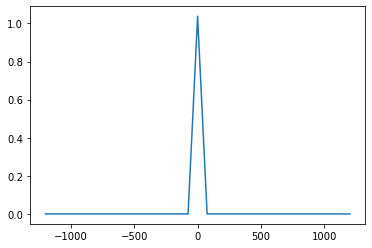

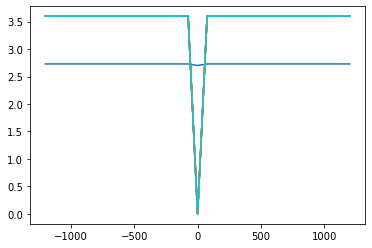

In [212]:
#Affichage

for n in range(1, N, 10):
    plt.plot(x, np.exp(Phi[n]))
plt.show()

for n in range(1, N, 10):
    plt.plot(x, np.exp(Nu[n]))
plt.show()